<a href="https://colab.research.google.com/github/taemmini/2023_Fall_HUFS_ML_Project_7/blob/main/CAPTCHA_Project_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras import layers

import cv2
from sklearn.model_selection import train_test_split

In [26]:
images = glob(r".\resource\CAPTCHA1\*.jpeg")
print(images[0].split(os.path.sep)[3].split('.jpeg')[0].split('_')[1].upper())

VGXRUB


In [27]:
labels = [img.split(os.path.sep)[3].split('.jpeg')[0].split('_')[1].upper() for img in images]
print(len(labels))

10001


In [28]:
unique_char = set(''.join(labels))
print(unique_char)
print(len(unique_char))

{'S', 'T', 'F', 'U', 'E', 'N', '2', 'B', 'X', 'H', 'K', 'G', 'A', 'M', 'C', 'D', 'V', '6', 'R', 'Z', 'P'}
21


In [29]:
# label 인코딩

# Keras에서 제공하는 문자열 -> 숫자 label 매칭을 사용해 label을 int로 바꿈
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(unique_char), num_oov_indices = 0, mask_token = None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)

C:\Users\yongh\anaconda3\Lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [30]:
# 인코딩 테스트
print(labels[0], end=" / ")
example = char_to_num(tf.strings.unicode_split(labels[0], input_encoding = 'UTF-8'))
print(example)

VGXRUB / tf.Tensor([16 11  8 18  3  7], shape=(6,), dtype=int64)


In [31]:
# 한국어도 가능한가?
test_set = set(["가","나","다","라","마","걁","샯"])
char_to_num_test = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(test_set), num_oov_indices = 0, mask_token = None
)
num_to_char_test = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num_test.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)
test_hangul_label = '가라걁다샯'
example_hangul = char_to_num_test(tf.strings.unicode_split(test_hangul_label, input_encoding = 'UTF-8'))
print(example_hangul)

tf.Tensor([1 0 4 3 5], shape=(5,), dtype=int64)


In [32]:
# 디코딩 테스트 (tf -> numpy byte array -> decode)

print(tf.strings.reduce_join(num_to_char(example)).numpy().decode('utf-8'))
print(tf.strings.reduce_join(num_to_char_test(example_hangul)).numpy().decode('utf-8'))

# 문제없이 작동함을 확인

VGXRUB
가라걁다샯


In [33]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=777)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

9000 1001
9000 1001


XZG6KX


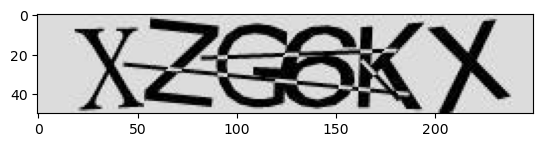

In [34]:
# 제대로 매칭되어 있는지 확인
sample = cv2.imread(x_train[0])
print(y_train[0])
plt.imshow(sample)

In [35]:
img_width = 200
img_height = 50

def encode_image(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])

  label = char_to_num(tf.strings.unicode_split(label, input_encoding = 'UTF-8'))

  return {'image':img, 'label':label}

VGXRUB
tf.Tensor([16 11  8 18  3  7], shape=(6,), dtype=int64)


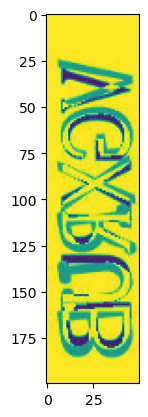

In [36]:
preview = encode_image(images[0], labels[0])
print(labels[0])
print(preview['label'])
plt.imshow(preview['image'])

In [37]:
# 모델에 넣을 데이터셋 구성(배치 학습이 아니기 때문에 정해진 배치사이즈마다 일정한 양의 데이터 묶음을 넣어 학습 진행)

batch_size = 32

# tf가 제공하는 Dataset을 사용하는게 학습이 더 빨라서 일반적으로 사용하는 것 같습니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(test_dataset)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [38]:
# CTC손실함수 정의 : 정형화된 구현 방법이 존재하여 그대로 가져왔습니다.

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [39]:
def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # Convolution, Maxpooling을 각각 두번하여 차원을 축소함

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNN을 두 차례 사용
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력층 구성
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # CTC 손실함수 적용
    output = CTCLayer(name='ctc_loss')(labels, x)

    # 모델 구성
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # 케라스에서 제공하는 최적화
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

In [40]:
#학습

model = build_model()

epochs = 100
stopping_patience = 10 # 10번의 epoch동안 개선이 없을 시 종료
#restore_best_weights : 조기종료 후 지금까지 최적값을 냈던 가중치를 다시 선택함
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
282/282 [==============================] - 21s 61ms/step - loss: 20.8186 - val_loss: 20.0926
Epoch 2/100
282/282 [==============================] - 16s 56ms/step - loss: 19.9571 - val_loss: 19.8086
Epoch 3/100
282/282 [==============================] - 16s 56ms/step - loss: 19.6675 - val_loss: 19.1648
Epoch 4/100
282/282 [==============================] - 16s 56ms/step - loss: 18.2949 - val_loss: 16.9230
Epoch 5/100
282/282 [==============================] - 16s 56ms/step - loss: 13.4292 - val_loss: 5.0737
Epoch 6/100
282/282 [==============================] - 16s 56ms/step - loss: 2.9632 - val_loss: 1.1808
Epoch 7/100
282/282 [==============================] - 16s 56ms/step - loss: 1.2109 - val_loss: 0.6406
Epoch 8/100
282/282 [==============================] - 16s 56ms/step - loss: 0.8613 - val_loss: 0.5483
Epoch 9/100
282/282 [==============================] - 16s 56ms/step - loss: 0.6927 - val_loss: 0.5250
Epoch 10/100
282/282 [==============================] - 16s 56ms

In [41]:
# model.save('./CRNN_model_re')

In [42]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    # encode된 글자를 복원하여 리스트에 저장
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

In [43]:
label_length = [len(label) for label in labels]
max_length = max(label_length)

In [54]:
# 시험해볼 이미지를 Tensor로 변환
preview = encode_image(images[0], labels[0])

# (중요) batch 차원을 더해줌
preview_tensor = tf.expand_dims(preview['image'],0)
print(preview_tensor)
pred = prediction_model.predict(preview_tensor)

tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]], shape=(1, 200, 50, 1), dtype=float32)
1/1 [==============================] - 1s 1s/step


In [59]:
pred_text = decode_batch_predictions(pred)
print(pred_text)
label = tf.strings.reduce_join(num_to_char(preview['label'])).numpy().decode('utf-8')
print(label)

['VGXRUB']
VGXRUB


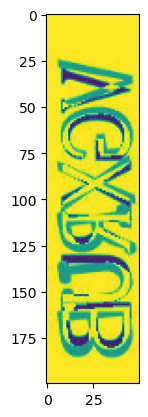

In [60]:
plt.imshow(preview['image'])

In [61]:
# Label을 인코딩하려면 char_to_num, num_to_char을 매 CAPTCHA 셋마다 별도로 생성해야하므로 수동으로 확인하기로 한다

# 이미지만 TF tensor로 변환
def encode_image_only(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])
    
  return img

In [62]:
test_images = glob(r".\resource\CAPTCHA2\*.png")
print(test_images[0].split(os.path.sep)[3].split('.png')[0])
print(len(test_images))
test_labels = [timg.split(os.path.sep)[3].split('.png')[0] for timg in test_images]

226md
1040


In [66]:
# 이미지를 텐서로 변환하고 배치차원 추가
test_sample = encode_image_only(test_images[0])
test_tensor = tf.expand_dims(test_sample,0)
print(test_sample)

tf.Tensor(
[[[0.75294125]
  [0.75294125]
  [0.75294125]
  ...
  [0.76470596]
  [0.76470596]
  [0.76470596]]

 [[0.75294125]
  [0.75294125]
  [0.75294125]
  ...
  [0.76470596]
  [0.76470596]
  [0.76470596]]

 [[0.75294125]
  [0.75294125]
  [0.75294125]
  ...
  [0.76470596]
  [0.76470596]
  [0.76470596]]

 ...

 [[0.9843138 ]
  [0.9843138 ]
  [0.9843138 ]
  ...
  [0.9960785 ]
  [0.9960785 ]
  [0.9960785 ]]

 [[0.9843138 ]
  [0.9843138 ]
  [0.9843138 ]
  ...
  [0.9960785 ]
  [0.9960785 ]
  [0.9960785 ]]

 [[0.9843138 ]
  [0.9843138 ]
  [0.9843138 ]
  ...
  [0.9960785 ]
  [0.9960785 ]
  [0.9960785 ]]], shape=(200, 50, 1), dtype=float32)


In [67]:
pred = prediction_model.predict(test_tensor)
pred_text = decode_batch_predictions(pred)

1/1 [==============================] - 0s 54ms/step
['2266H[UNK]']


226md


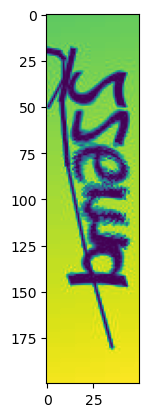

In [70]:
plt.imshow(test_sample)
print(test_labels[0])

# 예측 : '2266H[UNK]' / 정답 : 226md
# 학습 데이터가 대문자 + 숫자만으로 이루어져 소문자를 맞추지 못함.
# 또한 길이가 6인 데이터로만 학습하여 다른 길이의 데이터에 대해 대응하지 못함.
# data : https://www.kaggle.com/datasets/alizahidraja/captcha-data

1/1 [==============================] - 0s 57ms/step
['TTTC[UNK][UNK]']


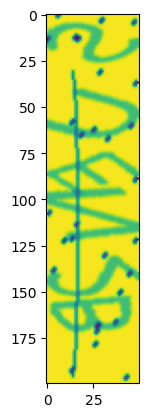

In [72]:
# 제가 시험삼아 생성한 CAPTCHA입니다.
# 데이터 상에서 등장했던 대문자 + 숫자의 조합 / 유사한 사이즈 / 동일하게 6자리
test_image_path = r".\resource\CAPTCHA.png"
test_label = 'SUEN2B'

test_sample = encode_image_only(test_image_path)
plt.imshow(test_sample)

test_tensor = tf.expand_dims(test_sample,0)
pred = prediction_model.predict(test_tensor)
pred_text = decode_batch_predictions(pred)
print(pred_text)

# 예측 : 'TTTC[UNK][UNK]', 정답 : 'SUEN2B'
# 새로운 종류의 노이즈에 매우 매우 취약함
# (확실하지 않음) Colored Captcha에 대응하지 못함

# 결론 : 모델이 덜 학습되었거나 Overfit된 것으로 보이나, 정황상 후자일 가능성이 높음.